## Recurrent Neural Network Acoustic Models for Speech Recognition

### Goals of the notebook

The project aim to show a complete step-by-step demonstration for **automatic speech recognition (ASR)** using **recurrent neural networks (RNN & LSTM)**. 

The approach follows the **natural flow of the data**, from brut audio signal to transcription. We will be explaining :

1. How the **data** are represented and the features extracted
2. How **sequential models** work with it
3. How is **alignment** learned and why it's crucial
4. What **improvements** let us achieve better performances

## Part I - Data and acoustic representation

### 1. Automatic speech recognition (ASR)

ASR is based on a simple concept, we have as input a **continuous audio signal**, and as output a **discrete sequence of symbols (phones, characters, words)**.

→ *Remark: Difference phones (/o/) VS characters (e a u)* 

Let's show what we've as input and output, we'll be using **torchaudio** which enable us to access to good datasets and methods to work on the data. 

In [ ]:
# Imports
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torcheval
import torchaudio
import soundfile
from IPython.display import Audio

print(f"Torch version: {torch.__version__}")
print(f"Torcheval version: {torcheval.__version__}")
print(f"Torchaudio version: {torchaudio.__version__}")

Torch version: 2.5.1
Torcheval version: 0.0.7
Torchaudio version: 2.5.1


In [3]:
# Downloading dataset LIBRISPEECH / 'dev-clean' -> small one 
# Creating data folder if it doesn't exists
if not os.path.exists('../data'):
    os.makedirs('../data')

dataset = torchaudio.datasets.LIBRISPEECH(
    root='../data', 
    url='dev-clean', 
    download=True
)

Text: MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL
Sample rate: 16000 Hz
Waveform tensor shape: Channel = 1 | Time = 93680


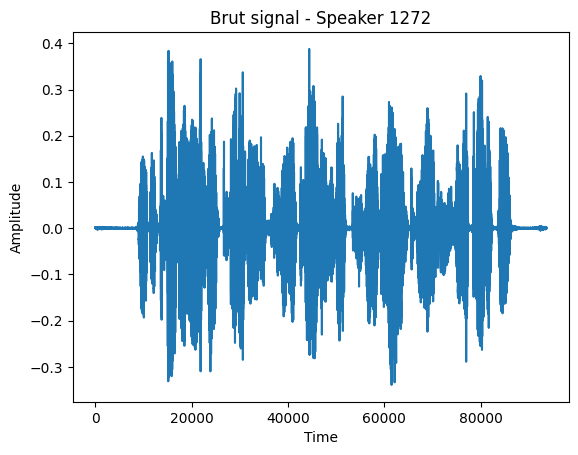

In [4]:
# Loading the first element of the dataset
waveform1, sample_rate1, transcript1, speaker_id1, chapter_id1, utterance_id1 = dataset[0]

print(f"Text: {transcript1}")
print(f"Sample rate: {sample_rate1} Hz")
print(f"Waveform tensor shape: Channel = {waveform1.shape[0]} | Time = {waveform1.shape[1]}")

# Plotting wave signal
plt.figure()
plt.plot(waveform1.t().numpy())
plt.title(f"Brut signal - Speaker {speaker_id1}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# Widget for listening the audio
Audio(waveform1.numpy(), rate=sample_rate1)

Text: NOR IS MISTER QUILTER'S MANNER LESS INTERESTING THAN HIS MATTER
Sample rate: 16000 Hz
Waveform tensor shape: Channel = 1 | Time = 77040


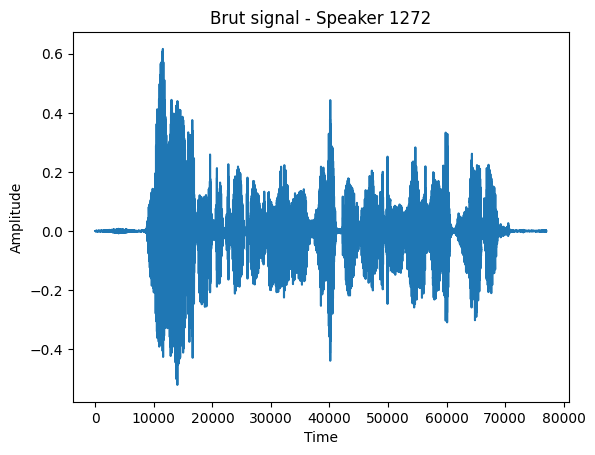

In [5]:
# Loading the first element of the dataset
waveform2, sample_rate2, transcript2, speaker_id2, chapter_id2, utterance_id2 = dataset[1]

print(f"Text: {transcript2}")
print(f"Sample rate: {sample_rate2} Hz")
print(f"Waveform tensor shape: Channel = {waveform2.shape[0]} | Time = {waveform2.shape[1]}")

# Plotting wave signal
plt.figure()
plt.plot(waveform2.t().numpy())
plt.title(f"Brut signal - Speaker {speaker_id2}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# Widget for listening the audio
Audio(waveform2.numpy(), rate=sample_rate2)

### 2. Audio data and temporal variability

Looking at the two last samples, we already see **key challenges**:
- *Variable Duration:* Input **audio length** varies significantly across samples.
- *Non-Constant Speaking Rate:* The **alignment between time and labels** is non-linear and fluctuates.
- *Articulation & Phonetic Context:* **Pronunciation** depends heavily on **neighboring sounds**.

Therefore, models must process **variable-length sequences** and capture **temporal context**. That's why, as we'll see, we turn to **Recurrent Neural Networks (RNNs)** like **LSTMs**, which are uniquely designed to model these non-linear temporal dependencies by maintaining a memory of past inputs.

*Remark:* One could say that the issue of variable duration isn't solved using bidirectional LSTM (which will be also used later), but in practice we can add padding and masking to the data in order to train on such data.

### 3. Features extraction & log-Mel filterbanks

To extract the features from an audio, we're going to cut the signal into **smaller windows of 25ms** and doing so each **10ms (stride)**. This will create a useful overlap, to get all the context. 

From each window, we then create a **80 dimensions feature**, following these steps:
1. First, we transform the **temporal signal in frequencies** (using Fast Fourier Transform).
2. Second, we have to filter this hugh spectrum. To represent at best what's perceived by the human ear, we use **Mel Filterbank**, which applied **80 triangular filters spaced according to the Mel scale** (which **imitate human hearing**).
3. Finally, we're taking the **log of the obtained energy.** 

This new representation is way more stable than the original signal and as it's inspired from human perception, it should help the model to find the wanted phones.

All these operations can be done using the *torchaudio* library.

In [6]:
sample_rate = 16000
win_length = int(0.025 * sample_rate)               # normalized win_length to have the number of samples
hop_length = int(0.01 * sample_rate)                # same for the stride
n_fft = 2 ** int(np.ceil(np.log2(win_length)))      # highest power of 2 that can fit in the window
n_mels = 80                                         # 80 dimensions features 

wave_to_mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate, 
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    n_mels=n_mels      
)

spectrogram_to_log = torchaudio.transforms.AmplitudeToDB()

# Pipeline extracting the features
extracting_pipeline = torch.nn.Sequential(
    wave_to_mel_spectrogram,
    spectrogram_to_log
)

# Function to plot spectrogram
def plot_spectrogram(waveform : torch.Tensor) -> None:
    # Computing spectrogram
    spectrogram = extracting_pipeline(waveform)

    # Conversion in numpy
    wav_numpy = waveform[0].detach().cpu().numpy()
    spec_numpy = spectrogram[0].detach().cpu().numpy()

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))

    # PLOT 1 : Signal (Waveform) 
    axs[0].plot(wav_numpy)
    axs[0].set_title('Original Signal')
    axs[0].set_ylabel('Amplitude')
    axs[0].set_xlabel('Time (Frames)')
    axs[0].set_xlim([0, len(wav_numpy)]) 
    axs[0].grid(True, alpha=0.3)

    # PLOT 2 : Spectrogram 
    # origin='lower' : to have low frequencies at beginning
    im = axs[1].imshow(spec_numpy, origin='lower', aspect='auto')
    
    axs[1].set_title('Log-Mel Spectrogram (dB)')
    axs[1].set_ylabel('Frequencies')
    axs[1].set_xlabel('Time (Frames)')
    
    # Color bar for dB scale
    fig.colorbar(im, ax=axs[1], format='%+2.0f dB')
    plt.tight_layout()
    plt.show()
    
# Function to plot the spectrogram on one specific window 
def plot_window_spectrogram(waveform: torch.Tensor, window_ind: int) -> None:    
    # Computing spectrogram
    # Expected shape: [1, 80, T]
    spectrogram = extracting_pipeline(waveform)

    if window_ind >= spectrogram.shape[2] or window_ind < 0:
        raise ValueError(f"Window index {window_ind} out of range. Max frame is {spectrogram.shape[2] - 1}")

    # Extracting window spectrogram
    window_data = spectrogram[0].detach().cpu().numpy()[:, window_ind]

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 4))
    x_indices = np.arange(len(window_data))
    ax.bar(x_indices, window_data, color='skyblue', edgecolor='#404040', width=0.8)
    ax.set_title(f'Energy distribution (Log-Mel) at frame {window_ind}')
    ax.set_xlabel('Mel filter index (0=low -> 79=high)')
    ax.set_ylabel('Amplitude (dB)')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.set_xlim(-1, 80)
    plt.show()


Shape Audio 1 : torch.Size([1, 93680]) -> Spec 1 : torch.Size([1, 80, 586])
Shape Audio 2 : torch.Size([1, 77040]) -> Spec 2 : torch.Size([1, 80, 482])


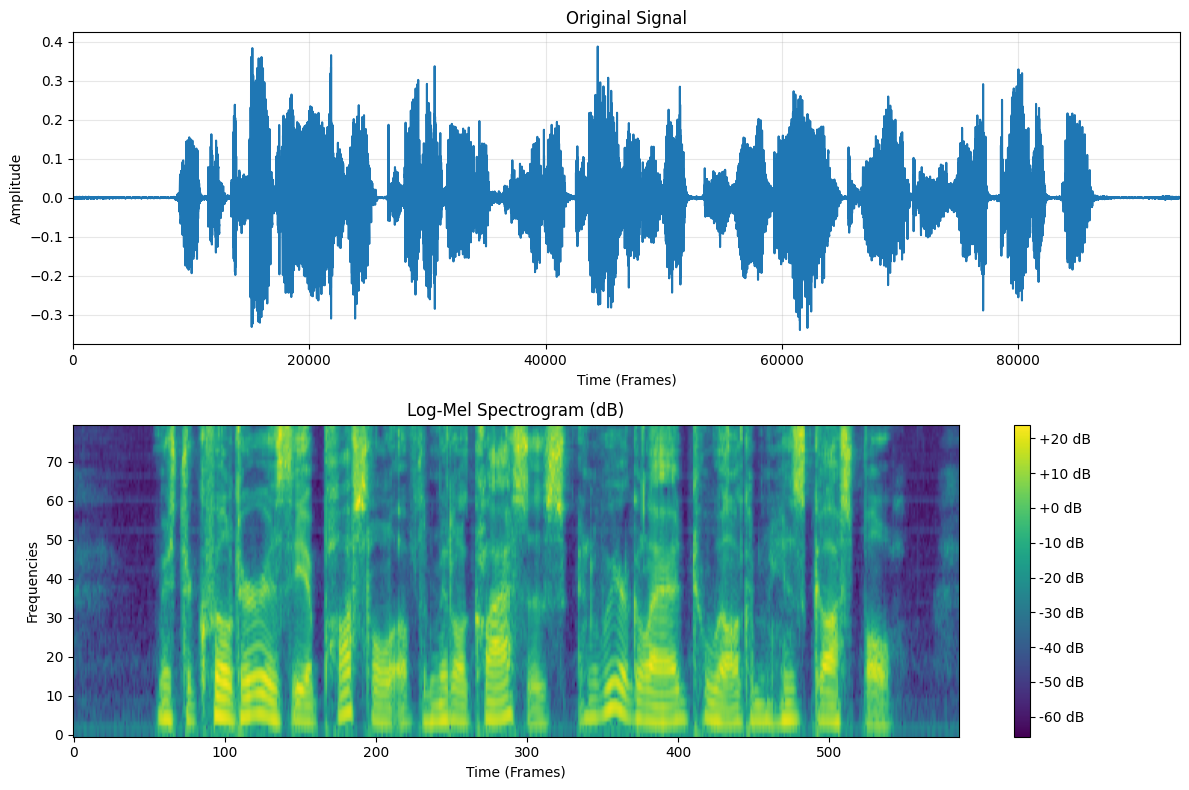

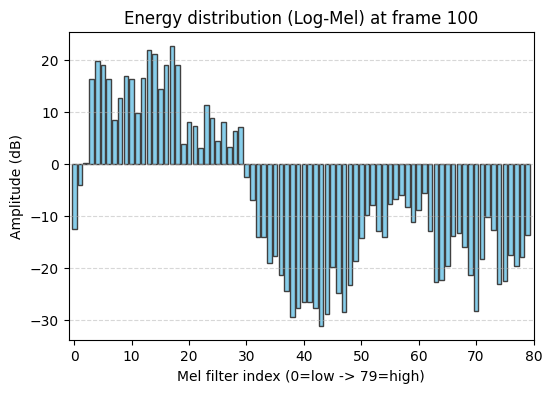

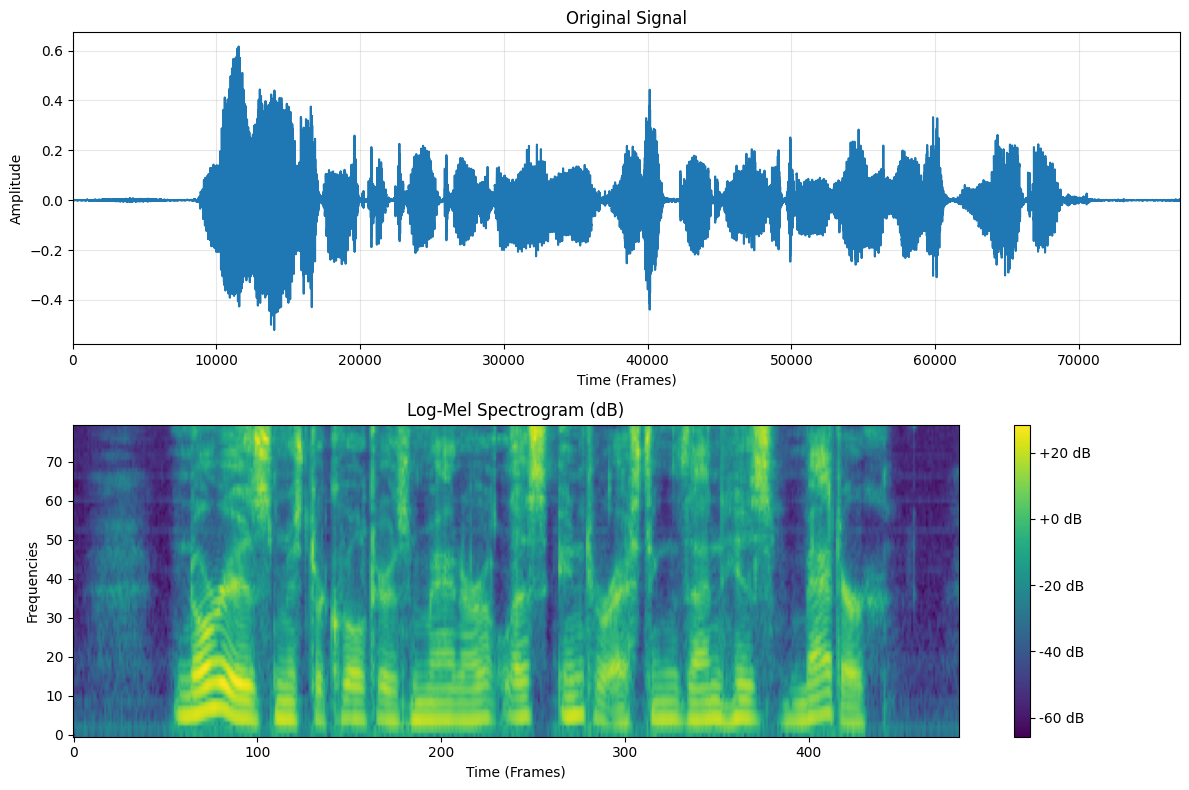

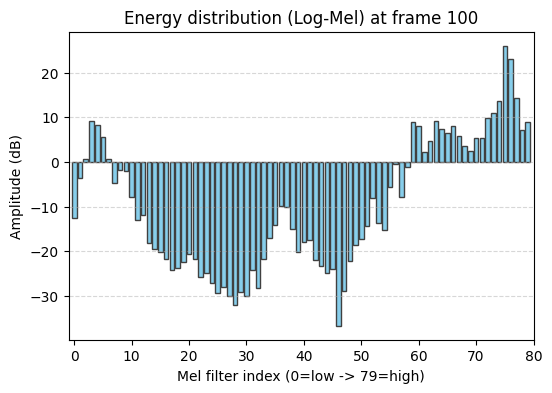

In [7]:
# Testing on loaded data 
spec1 = extracting_pipeline(waveform1)
spec2 = extracting_pipeline(waveform2)

print(f"Shape Audio 1 : {waveform1.shape} -> Spec 1 : {spec1.shape}")
print(f"Shape Audio 2 : {waveform2.shape} -> Spec 2 : {spec2.shape}")

plot_spectrogram(waveform1)
plot_window_spectrogram(waveform1, 100)
plot_spectrogram(waveform2)
plot_window_spectrogram(waveform2, 100)

## Part II - Sequential modeling with RNN/LSTM

### 4. What RNN have replaced and why ?
#### A. GMM-HMM older state of the art

The GMM-HMM framework was the statistical approach that divides speech recognition into two distinct components:

***Hidden Markov Model (Sequence Manager):*** It models the temporal structure of speech as a sequence of states (beginning/middle/and end of a phoneme). It relies on the Markov assumption, meaning it predicts the next state only based on the current one, lacking the long-term memory found in modern models.

***Gaussian Mixture Model (Acoustic Observer):*** It handles the actual sound data by fitting Gaussian curves to short audio windows (25ms) to calculate the probability of a sound matching a specific state. Because GMMs struggle with correlated data (like Mel-log spectrograms), they require decorrelated inputs, such as MFCCs (similar to Mel-Log but adding a Discrete Cosine transformation for decorrelating data).

#### B. The arrival of RNN and LSTM

As we've seen the older state of the art faced important limitations, such as the frames independence hypothesis or the lose of temporal information. 

The **RNN architecture** provide a solution to both of these issues, as it's treating sequentially the information and as it keep in memory previous information.


<img src="../img/unrolled.png">

However, RNN still show some weaknesses especially with the **vanishing gradient** issue and the **computational and time cost**, which is really heavy with such architecture. 

That let us introduce the **Long Short-Term Memory (LSTM) architecture**, which provide a solution to this vanishing problem and which captures long term dependencies using its *"Conveyor Belt"* (original image popularized by *Christopher Olah* in its reference article on LSTM).


<img src="../img/lstm.png">

Let's implement a **class *SpeechRecognition* using LSTM** and the characteristics of the original paper : *Fast and Accurate Recurrent Neural Network Acoustic Models for Speech Recognition*, Sak & All.

In [ ]:
Unidirectional LSTM :
Input (x):      x1      x2      x3 ...    x_end
                 |       |       |           |
               [LSTM]→ [LSTM]→ [LSTM]→ ... [LSTM] 
                 |       |       |           |   ↘
Output :        o1      o2      o3 ...    o_end   (h_end, c_end)

Bidirectional LSTM :
Input (x):      x1      x2      x3 ...    x_end
                 |       |       |           |
               [LSTM]→ [LSTM]→ [LSTM]→ ... [LSTM]
                 |       |       |           |
               [LSTM]← [LSTM]← [LSTM]← ... [LSTM]                
                 |       |       |           |   ↘
Output :        o1      o2      o3 ...    o_end   (h_end, c_end)

In [8]:
# input_dim : number of features per window => 80
# hidden_dim : 512 or 256 for bidirectional => in article normally 500 and 300, but I prefer power of 2 
# output_dim : vocabulary size + 1 token blank space => for computational reasons we take 29
# n_layers : 5 according to the article

class SpeechRecognition(nn.Module):
    def __init__(self, input_dim : int, hidden_dim : int, output_dim :int, n_layers : int, bidirectional : bool) -> None:
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.bidirectional = bidirectional

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=self.input_dim,          # Input dim
            hidden_size=self.hidden_dim,        # Hidden dim
            num_layers=self.n_layers,           # Num layers
            bidirectional=self.bidirectional,   # Bidirectional
            batch_first=True,                   # Batch first
            dropout=0.1                         # To avoid overfitting
        )
        
        # Output dim - if bidirectional output size 2 time longer
        lstm_output_dim = self.hidden_dim * 2 if bidirectional else self.hidden_dim
        
        # Output layer for classification
        self.classifier = nn.Linear(lstm_output_dim, self.output_dim)

    def forward(self, x) -> torch.Tensor:
        # x : shape (Batch, Time, input_dim)
        output, _ = self.lstm(x)                    # output : shape (Batch, Time, lstm_output_dim)
        logits = self.classifier(output)            # logits : shape (Batch, Time, output_dim) -> output_dim = size vocabulary, taking dim=2 in log_softmax to compute proba on this and not batch or time
        log_proba = F.log_softmax(logits, dim=2)    # we normalize the logits to have probability and take log of these, to avoid numerical 0
        return log_proba

## Part III - Alignment issue and solution

### 5. Missing of explicit alignment 

One of the key issue with ASR is the **alignment of the frame** with the known transcriptions. In the classical approach, we face a limitation with the **Cross-Entropy loss**, as it relies on strict, fixed alignments to calculate error, therefore it's difficult to perform a good training.

Also generating these frame-level alignments manually is **really expensive and inefficient**, meaning traditional methods are impractical for large-scale data.

To face this issue we introduce Connectionist temporal classification in the next part. 

### 6. Connectionist temporal classification (CTC)

CTC can be implemented with a softmax output layer using an **additional unit for the blank label** used to estimate the probability of outputting no label at a given time. 

The output label probabilities from the network define a probability distribution over **all possible labelings of input sequences including the blank labels.** The network can be trained to **optimize the total log probability of correct labelings** for training data, meaning the network doesn't learn one specific alignment but optimize the total log probability of alignment.

In the end we use a CTC loss, already implementing in torch (https://docs.pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html). 

Décodage CTC
- Suppression des répétitions
- Suppression des blanks
- Décodage greedy (simplifié)


In [9]:
# Defining the vocabulary used to map the text to numbers
class TextTransform:
    def __init__(self) -> None:
        # We map text to integers (and reverse) using this coding 
        # The library LibriSpeech is already normalized, we're using it's norm 
        # 0 -> Blank
        # 1 -> '
        # 2 -> Space
        # 3 -> a ...

        self.__char_map = {}
        self.__index_map = {}

        # First the blank, ' and space 
        self.__char_map["<BLANK>"] = 0
        self.__index_map[0] = "<BLANK>"
        self.__char_map["'"] = 1
        self.__index_map[1] = "'"
        self.__char_map[" "] = 2
        self.__index_map[2] = " "

        # The rest of the characters
        for i, char in enumerate("abcdefghijklmnopqrstuvwxyz"):
            self.__char_map[char] = i + 3
            self.__index_map[i + 3] = char

    def text_to_int(self, text) -> list[int]:
        # Mapping the text to integers
        int_list = []
        for char in text.lower():
            if char in self.__char_map:
                int_list.append(self.__char_map[char])
        return int_list
        
    def int_to_text(self, list) -> str:
        # Mapping the integers to text
        text = ""
        for integer in list:
            idx = integer.item() if hasattr(integer, "item") else integer
            text += self.__index_map[idx]
        return text
    
text_transform = TextTransform()

### 7. Decoding the output

To decode the output of the model we're going to build a simplified decoder that works in two steps : 
* remove repetition of consecutive letter : aa -> a, bb -> b, ...
* remove blanks
* unpad the label using the true label if given

In [ ]:
def greedy_decoding(output, labels=None, label_lengths=None):
    arg_maxes = torch.argmax(output, dim=2) # output shape [Batch, Time, Vocabulary] 
    decodes = []
    targets = []

    for i, args in enumerate(arg_maxes):
        decode = []

        # Removing consecutive similar sample
        pred_integers = torch.unique_consecutive(args)

        # Removing blank 
        for token in pred_integers:
            if token != 0: # Blank token
                decode.append(token)

        decode_str = text_transform.int_to_text(decode)
        decodes.append(decode_str)

        # Decoding the target label if given
        if labels is not None and label_lengths is not None:
            target_length = label_lengths[i]
            target_label = labels[i][:target_length].tolist() # Ignoring padding in the label
            target_str = text_transform.int_to_text(target_label) 
            targets.append(target_str)

    if labels is not None:
        return decodes, targets
    else:
        return decodes
    

# Updating word error rate to compensate the greedy decoding -> metric used during training and validation
from torcheval.metrics.functional import word_error_rate
def word_error_rate_updated(input, target): 
    target = re.sub(r"(.)\1+", r"\1", target) # Removing similar following letters 
    return word_error_rate(input, target)

### 8. Padding & resizing 

We also have to handle the point of different size of training audio. To do so, we're going to process a bit the data doing some **padding to have always same size input.**

We also need to take care of the **dimensions**, actually our `extracting_pipeline`  returns a tensor of shape `[1, n_mels, Time]` but our LSTM has been instanced to take `[Batch_size,Time,n_mels]`.

We will build a function `data_processing` that will be given as argument to the dataloader.

In [ ]:
def data_processing(data): # data input as in the first example 
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []

    for (waveform, _, transcript, _, _, _) in data:
        # 1. SPECTROGRAM
        # Going throw transforming pipeline defined earlier
        # Input : [1, Time]
        # Output : [1, n_mels, Time]
        spec = extracting_pipeline(waveform)

        # Transforming dimensions 
        # Input : [1, n_mels, Time]
        # Output : [Time, n_mels]
        spec = spec.squeeze(0).transpose(0,1)
        spectrograms.append(spec)

        # 2. LABEL
        # Using the earlier class text_transform to compute the label
        label = torch.Tensor(text_transform.text_to_int(transcript.lower()))
        labels.append(label)

        # 3. LENGTHS
        input_lengths.append(spec.shape[0])
        label_lengths.append(len(label))

    # Padding to have same size input 
    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths

Let's build the **train and testing set**, and their respective **dataloader** (in next section, we fix the batch size as an hyperparameter).

In [ ]:
from torch.utils.data import random_split, DataLoader, Subset

# Keeping only a proportion of the initial dataset to train faster
reduced_percentage = None # or 0.1 to keep 10%, etc
if reduced_percentage is not None:
    dataset_size = len(dataset)
    final_size = int(dataset_size * reduced_percentage)
    subset_indices = range(0, final_size)
    dataset_reduced = Subset(dataset, subset_indices)

# Splitting the dataset in 80/20
total_length = len(dataset_reduced)
train_length = int(0.8 * total_length)
test_length = total_length - train_length

# Building a fixed random generator for replicability
gen = torch.Generator().manual_seed(42)
train_set, test_set = random_split(dataset_reduced, [train_length, test_length], generator=gen)

## Part IV - Training a first model and decoding the output

Let's train our first speech recognition model and decode the results. For this first try, we're going to use and **AdamW optimizer** and as explained before a **CTCloss**.

### 7. Training the model

Below is the code to train different model, based on what we've seen until now. In the folder model you can find different model (uni/bi directional, trained with different epoch and learning rate), that can be loaded directly.

* asr_v2 : 25 epochs | lr 1e-4 | reduced_percentage : None | batch_size : 10 | bidirectional | 256/5 layers
* asr_v3 : 150 epochs | lr 5e-5 | reduced_percentage : None | batch_size : 10 | bidirectional | 256/5 layers

#### 7.1 Setting loop

In [ ]:
# Setting up the model and the hyperparameters

# 1. Moving to GPU 
if torch.cuda.is_available():
    device = torch.device("cuda")
#elif torch.backends.mps.is_available(): # CTCloss not available on mps
#    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Training on : {device}")

# 2. Hyperparameter
learning_rate = 1e-4
batch_size = 10
epochs = 10

# 3. DataLoader
train_loader = DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_processing,
    drop_last=True # Dropping last batch if incomplete to avoid bugs
)

test_loader = DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_processing,
    drop_last=True # Dropping last batch if incomplete to avoid bugs
)

# 4. Model
model = SpeechRecognition(
    input_dim=80,
    hidden_dim=256,
    output_dim=29, 
    n_layers=5,
    bidirectional=True
).to(device)

# 5. Optimizer & Loss
optimizer = torch.optim.AdamW(model.parameters(), learning_rate)
criterion = nn.CTCLoss(blank=0, zero_infinity=True)

Training on : cpu


#### 7.2 Training loop

In [ ]:
# --- Saving configuration ---
model_version = "Vx" # Code to know to which model it refers 
epoch_to_resume = 10
checkpoint_path = f"../model/{model_version}/checkpoint_epoch_{epoch_to_resume}.pth" 
start_epoch = 0

if not os.path.exists(f'../model/{model_version}'):
    os.makedirs(f'../model/{model_version}')

# --- Starting block ---
if os.path.exists(checkpoint_path):
    print(f"Backup found at '{checkpoint_path}'. Loading...")
    checkpoint = torch.load(checkpoint_path)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    train_loss_memory = checkpoint['train_loss_memory']
    val_loss_memory = checkpoint['val_loss_memory']
    train_wer_memory = checkpoint['train_wer_memory']
    val_wer_memory = checkpoint['val_wer_memory']

    print(f"Training restart at {start_epoch + 1}")
else:
    train_loss_memory = []
    val_loss_memory = []
    train_wer_memory = []
    val_wer_memory = []
    print("No backup found. Starting from zero.")


# --- Training ---
for epoch in range(start_epoch, epochs):

    # --- Training ---
    model.train()
    train_epoch_loss = 0.0
    train_preds = []
    train_targets = []
    
    for batch_idx, (spectrograms, labels, input_lengths, label_lengths) in enumerate(train_loader):
        # Sending to device
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Reset gradient
        optimizer.zero_grad()

        # Forward pass
        log_probs = model(spectrograms)

        # Reshape -> CTCloss want [Time, Batch, Vocabulary]
        log_probs = log_probs.transpose(0, 1)

        # Loss
        loss = criterion(log_probs, labels, input_lengths, label_lengths)

        # Backward & updating weights
        loss.backward()
        optimizer.step()

        # Sum epoch loss
        train_epoch_loss += loss.item()

        # Decoding prediction to compute word error rate at the end of the epoch
        decoded_preds, decoded_targets = greedy_decoding(
            log_probs.transpose(0, 1), 
            labels, 
            label_lengths
        )
        train_preds += decoded_preds
        train_targets += decoded_targets

    # Averaging epoch loss
    train_avg_loss = train_epoch_loss / len(train_loader)
    train_loss_memory.append(train_avg_loss)
    train_wer_memory.append(word_error_rate_updated(train_preds, train_targets))


    # --- Validation ---
    model.eval()
    val_epoch_loss = 0.0
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for batch_idx, (spectrograms, labels, input_lengths, label_lengths) in enumerate(test_loader):
            # Sending to device
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)

            # Forward pass
            log_probs = model(spectrograms)

            # Reshape -> CTCloss want [Time, Batch, Vocabulary]
            log_probs = log_probs.transpose(0, 1)

            # Loss
            loss = criterion(log_probs, labels, input_lengths, label_lengths)

            # Sum epoch loss
            val_epoch_loss += loss.item() 
    
            # Decoding prediction to compute word error rate at the end of the epoch
            decoded_preds, decoded_targets = greedy_decoding(
                log_probs.transpose(0, 1), 
                labels, 
                label_lengths
            )
            val_preds += decoded_preds
            val_targets += decoded_targets

    # Averaging epoch loss
    val_avg_loss = val_epoch_loss / len(test_loader)
    val_loss_memory.append(val_avg_loss)
    val_wer_memory.append(word_error_rate_updated(val_preds, val_targets))

    print(f"--- END Epoch {epoch + 1} / {epochs} | Average training loss {train_avg_loss:.4f} | Average validation loss {val_avg_loss:.4f} ---")

    # --- Saving at the end of an epoch ---
    torch.save({
        'epoch': epoch + 1, 
        'train_loss_memory': train_loss_memory,
        'val_loss_memory': val_loss_memory,
        'train_wer_memory': train_wer_memory,
        'val_wer_memory': val_wer_memory,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, f"../model/{model_version}/checkpoint_epoch_{epoch}.pth")
    print(f"End epoch model saved")

# Saving model
saving_path = f"../model/{model_version}/{model_version}_final.pth"
torch.save({
    'train_loss_memory': train_loss_memory,
    'val_loss_memory': val_loss_memory,
    'train_wer_memory': train_wer_memory,
    'val_wer_memory': val_wer_memory,
    'model_state_dict': model.state_dict()
}, saving_path)
print(f"Saved under name : {saving_path}")

Epoch 1 | Batch 0 | Loss 19.5966
Epoch 1 | Batch 10 | Loss 16.5684
Epoch 1 | Batch 20 | Loss 3.2868
Epoch 1 | Batch 30 | Loss 3.5503
--- END Epoch 1 / 1 | Average loss 10.0202 ---


#### 7.3 Loading pre-trained model 

In [ ]:
print("\n--- LOADING MODEL ---")
model_version = "Vx" # Code to know to which model it refers 
backup = torch.load(f"../model/{model_version}/{model_version}_final.pth", map_location=device)

model = SpeechRecognition(
    input_dim=80,
    hidden_dim=256,
    output_dim=29, 
    n_layers=5,
    bidirectional=True
)

model.load_state_dict(backup['model_state_dict'])
train_loss_memory = backup['train_loss_memory']
val_loss_memory = backup['val_loss_memory']
train_wer_memory = backup['train_wer_memory']
val_wer_memory = backup['val_wer_memory']

/var/folders/0x/tnwyycrs76jb4wzv1753ymx40000gn/T/ipykernel_1529/1744036188.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../model/as

<All keys matched successfully>

#### 7.4 Model results 

In [ ]:
def plot_results(train_loss_memory, val_loss_memory):
    model.eval()
    test_loss = 0
    print("\n--- STARTING EVALUATION ---")
    
    with torch.no_grad():
        for i, (spectrograms, labels, input_lengths, label_lengths) in enumerate(test_loader):
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)

            output = model(spectrograms)  # [Batch, Time, Classes]
            output = output.transpose(0, 1)  # [Time, Batch, Classes] for CTC Loss
            
            loss = criterion(output, labels, input_lengths, label_lengths)
            test_loss += loss.item()

            # Decoding
            decoded_preds, decoded_targets = greedy_decoding(
                output.transpose(0, 1), 
                labels, 
                label_lengths
            )
            
            if i == 0:
                # Showing min between 3 and number batch 
                num_to_print = min(3, len(decoded_preds))
                for j in range(num_to_print):
                    print(f"Target:  {decoded_targets[j]}")
                    print(f"Predict: {decoded_preds[j]}")
                    print("-" * 20)

    avg_loss = test_loss / len(test_loader)
    print(f"Validation Loss: {avg_loss:.4f}")
    return avg_loss

Training this way doesn't work well, of course we could go for more epochs, but there's a deeper point to face : with really short frame and difficulty to handle context from previous and further frames, the model doesn't perform well. To answer this, we implement two things :
* concatenation of frames (stacking)

## Part IV - Improving the acoustic models

### 7. Frame stacking and subsampling
Motivation
- Réduction du nombre de frames
- Stabilisation de l’entraînement CTC
- Accélération du calcul

Implémentation
- Concaténation de plusieurs frames
- Sous-échantillonnage temporel

* **Input:** A sequence of 100 frames (10 ms).
* **Processing:** Stack groups of 3 or 8 frames + sub-sampling (skip frames).
* **Output:** A shorter but richer sequence.

### 8. Context-Dependent Phones
Principe
- Un phonème dépend de son contexte
- Modélisation plus fine des transitions phonétiques

Bénéfices
- Contraintes plus fortes sur le décodage
- Réduction du Word Error Rate

*(implémentation simplifiée dans le projet)*

### 9. State-level Minimum Bayes Risk (sMBR)
Limite de CE / CTC
- Optimisent une loss locale
- Pas directement le WER

sMBR
- Optimisation directe au niveau séquence
- Amélioration significative des performances

*(discuté conceptuellement)*


## Part V - Going further

### _. Extensions of presented models
- Comparaison unidirectionnel vs bidirectionnel
- Effet du frame stacking
- CTC caractère vs phonème

### _. Modern models  
- Attention-based models
- Transformers / Conformers
- Rôle fondamental de CTC dans les systèmes actuels

### _. Conclusion

- Les RNN/LSTM sont naturellement adaptés à la parole
- CTC permet d’apprendre l’alignement automatiquement
- Les améliorations d’ingénierie sont cruciales
- Le projet montre le passage complet :
